In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
from tqdm.notebook import tqdm

# Data

In [2]:
### import data
DataFile = 'data/A2_rev1.csv' # change this
data2 = pd.read_csv(DataFile).set_index('ID')

## Welsch t-test

In [3]:
def calculate_welsch_t(a, b):
    numerator = np.mean(a) - np.mean(b)
    denominator = np.sqrt(np.var(a)/len(a) + np.var(b)/len(b))
    return numerator / denominator

def simulate_welsch_t(a, aerr, b, berr, reps=10000):
    """Simulate the observation under similar condition along with the null hypothesis be that 
    a and b come from distribution of the same mean. 
    
    1. By simlar observing conditions we mean, we randomly choose an observation from a or b with equal chance without replacement (aka bootstrap sampling) 
       and sample the Gaussian distribution with parameters from that obseration's mean and error (aka Monte Carlo sample). 
    2. The above is repeated until we have a resample of `a` (of the same size) and a resample of `b` (of the same size).
    2. We then calculate the Welsch t-statistics with the two resamples above 
    3. We repeat these steps `reps` times resulting a null distribution of Welsch t-statistics (not to be confused with the t-distribution)
    
    The resulting null distribution can be used as a test against null hypothesis by finding the chance (p-value) that the empirical Welsch t-statistics of the original samples `a` and `b` is observed
    using the null distribution. If the p-value is greater than some threshold, then the null hypothesis can be rejected that the samples `a` and `b` come from the distributions with the same mean.
    
    """
    null_means = np.concatenate([a, b])
    null_errors = np.concatenate([aerr, berr])
    
    ts = []
    for _ in tqdm(range(reps)):
        # Simulate observing the first sample
        indices = np.random.choice(range(len(null_means)), size=len(a))
        sample1 = stats.norm.rvs(loc=null_means[indices], scale=null_errors[indices])
        assert len(sample1) == len(a), "The first bootstrapped sample must be the same size as sample `a`."
        
        # Simulate observing the second sample
        indices = np.random.choice(range(len(null_means)), size=len(b))
        sample2 = stats.norm.rvs(loc=null_means[indices], scale=null_errors[indices])
        assert len(sample2) == len(b), "The second bootstrapped sample must be the same size as sample `b`."
        
        # Calculate the statistics
        t = calculate_welsch_t(sample1, sample2)
        ts.append(t)
        
    return np.array(ts)

  0%|          | 0/50000 [00:00<?, ?it/s]

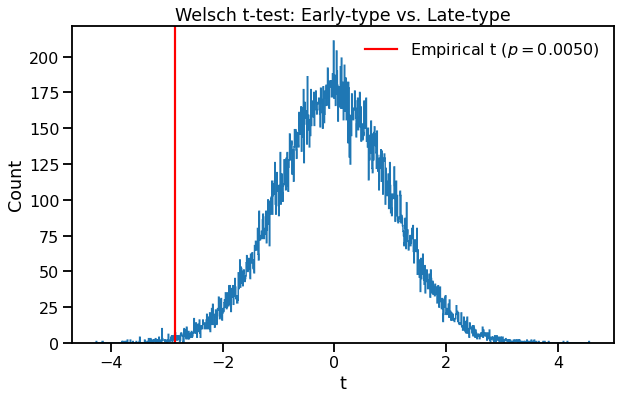

In [4]:
### test with binning (E,S0), (Sbc,Sdm) -- statistically significant :)

### morphology binning
early_type = ['E', 'E?', 'E/S0', 'S0', 'S0-', 'S0⚬', 'S0+']#, 'S0a', 'Sa'] 
late_type  = ['Sbc','Sc', 'Scd','Sd','Sdm']

### apply binning
A = data2[data2['morphology'].isin(early_type)]['HR']
Aerr = data2[data2['morphology'].isin(early_type)]['HR_err']
B = data2[data2['morphology'].isin(late_type)]['HR']
Berr = data2[data2['morphology'].isin(late_type)]['HR_err']

### Z-test
results = simulate_welsch_t(A, Aerr,  B, Berr, reps=50000)
empirical_t = calculate_welsch_t(A, B)
pvalue = np.mean(np.abs(results) >= np.abs(empirical_t))  # Two-tailed pvalue

### plot
plt.figure(figsize=(10, 6),dpi=70)
plt.hist(results, histtype="step", bins=len(results)//50)
plt.axvline(empirical_t, c='r', label=f"Empirical t ($p={pvalue:.4f}$)")
plt.title("Welsch t-test: Early-type vs. Late-type")
plt.xlabel("t")
plt.ylabel("Count")
plt.legend(frameon=False)

In [7]:
data2['morphology'].isin(late_type).sum()

108

In [8]:
data2.shape

(293, 17)

# Questions to be answered

1. How do we quantify the uncertainty in the separation of mean values?
2. How do we respond to the referee comment below?
> ### Question 2
> I maybe just misunderstanding what is happening, if so, then please clarify the text. But Section 4.1 describes a bootstrap-like error analysis and then a Welsch t-test to determine if those bootstrapped distributions are the same or not. However, in my quick analysis, the significance of the Welsch t-test will be dependant on the number of bootstrap samples. See the quick example blow. I use `scipy.stats.ttest_ind()` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) with `equal_var=False` to calculate the Welsch t-test.

    ```py
    Python 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 20:58:55)
    [Clang 11.0.0 ] on darwin
    Type "help", "copyright", "credits" or "license" for more information.
    >>> from scipy import stats
    >>> import numpy as np
    >>> np.random.seed(12345678)
    >>> k20_small = stats.norm.rvs(loc=-0.3, scale=0.1,size=100)
    >>> k20_large = stats.norm.rvs(loc=-0.3, scale=0.1, size=10_000)
    >>> m21_small = stats.norm.rvs(loc=0.09, scale=0.12, size=100)
    >>> m21_large = stats.norm.rvs(loc=0.09, scale=0.12, size=10_000)
    >>> stats.ttest_ind(k20_small, m21_small, equal_var=False)
    Ttest_indResult(statistic=-22.10632174420448, pvalue=3.91482390773831e-53)
    >>> stats.ttest_ind(k20_large, m21_large, equal_var=False)
    Ttest_indResult(statistic=-249.44521603605736, pvalue=0.0)
    ```
    > Please clarify if your significance in section 4.1 is a result of the number of samples you selected for your bootstrap resampling.

**A:** That's a great point, the Welsch t-statistics is dependent on the sample size of the two samples in question. We re-programmed our simulation to more properly mimic observing the two samples without Gaussian broadening and found the significance to be much lower at a p-value of XX. In more details, the simulation was set up as follows:
       
    
1. Let the two empirical sample be A and B with sample size N and M respectively
2. Apply the null hypothesis that the two empirical sample come from distributions of the same mean. We did this by concatenating A and B; let's call this the null sample
3. We resample A under the null hypothesis by randomly picking N rows from the null sample. Each row contains the HR mean and uncertainty. The resampled A is produced by sampling the Gaussian distribution once per row with each row's respective HR mean as mu and uncertainty as sigma.
4. Repeat step 3 for resampling B
5. Calculate the Welsch t-statistics for the resampled A and B. 
6. Repeat 3-5 for YYYY times creating a null distribution of size YYYY
7. The empirical Welsch t-statistics (calculated from the original sample A and B) is compared against this distribution for the two-tailed p-value
    
This corrected simulation should rectify your concern; the Welsch t-test is done against the original sample sizes of A and B at all repetitions of the bootstrap simulation.

In [6]:
data2['SN1990af']

KeyError: 'SN1990af'